# Read data

In this section we reads the pickle files of Graph, training positive sample, training negative sample and test.csv files 
* Training pickle files are dictionaries with keys as (u,v) and values are list of path_length, Jaccard_coeff_pred and Jaccard_coeff_successor.

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import csv
# %pip install networkx
from tqdm import tqdm
# %pip install tqdm
import networkx as nx
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# caluculate the roc curve and auc score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


In [2]:
# Read the train.txt file using with open
with open('../data/train.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    data = {}
    for row in reader:
        data[int(row[0])] = [int(x) for x in row[1:]]

In [3]:
g = nx.DiGraph(data)

In [4]:
# print properties of graph g
print("Number of nodes:", g.number_of_nodes())
print("Number of edges:", g.number_of_edges())
print("Density:", nx.density(g))

Number of nodes: 4867136
Number of edges: 23945602
Density: 1.010831775855996e-06


In [5]:
list_no_followees = []
for i in data.keys():
    if len(data[i]) == 0:
        list_no_followees.append(i)
print(len(list_no_followees))

430


In [6]:
# Create bins for in_degree and out_degree
in_degrees = g.in_degree()
out_degrees = g.out_degree()


In [7]:
n1_nodes = list(set(list(data.keys())).difference(set(list_no_followees)))
train_ve = {}
total_nodes = list(g.nodes())

In [8]:
train_pos = {}

In [9]:
# Dictionary between node and out_degree of n1_nodes
n1_out_degrees = {}
for i in tqdm(n1_nodes):
    n1_out_degrees[i] = out_degrees[i]

bins_n1_nodes = {'0-10':[],'10-100':[],'100-1000':[],'1000-10000':[],'10000-100000':[],'100000-1000000':[]}
# create bins for n1_out_degrees.values()
for j,i in tqdm(n1_out_degrees.items()):
    if i >= 0 and i < 10:
        bins_n1_nodes['0-10'].append(j)
    elif i >= 10 and i < 100:
        bins_n1_nodes['10-100'].append(j)
    elif i >= 100 and i < 1000:
        bins_n1_nodes['100-1000'].append(j)
    elif i >= 1000 and i < 10000:
        bins_n1_nodes['1000-10000'].append(j)
    elif i >= 10000 and i < 100000:
        bins_n1_nodes['10000-100000'].append(j)
    elif i >= 100000 and i < 1000000:
        bins_n1_nodes['100000-1000000'].append(j)
print(bins_n1_nodes)

100%|██████████| 19570/19570 [00:00<00:00, 371315.03it/s]

{'0-10': [3932202, 1966283, 4128990, 1442017, 2031877, 2031882, 1638721, 262467, 3801429, 1507676, 1966515, 500, 4129311, 3408426, 4522612, 3015287, 4129435, 4326067, 393925, 4260667, 656276, 3670943, 1311667, 1639501, 4064381, 2753736, 1836279, 263446, 2884962, 460162, 3409286, 4720014, 3081633, 2033087, 4195785, 3868135, 1443360, 2819633, 4720198, 722525, 198359, 3278613, 1247012, 4065091, 1902, 3540903, 853954, 1181915, 985334, 1050902, 1247731, 3214161, 2821022, 3148705, 1117090, 134107, 1707086, 1838439, 1510810, 1969669, 724572, 2756232, 528070, 659187, 4591408, 2232142, 2166625, 1838972, 790647, 3346743, 4526569, 3478014, 1708597, 4788848, 1970818, 2232978, 4461288, 1577721, 4964, 3544020, 136177, 2823341, 2102449, 3544248, 2561261, 71431, 1906450, 1578771, 2627378, 3675991, 1513327, 4855715, 1578953, 661461, 2431061, 4724949, 3348717, 2890024, 4201023, 2497138, 3087015, 72431, 1579800, 6941, 2235211, 4463552, 3742829, 4594818, 1383637, 1842434, 3087634, 1383730, 4005320, 597494

In [10]:
for k,v in bins_n1_nodes.items():
    print(k,len(v))

0-10 1064
10-100 6377
100-1000 9250
1000-10000 2518
10000-100000 340
100000-1000000 21


In [11]:
s = 0
for i in bins_n1_nodes['0-10']:
    s += out_degrees(i)
print(s)

4418


In [26]:
# Randomly sampling the negative train edges.
c= 0 
while c < 30000:
    n1 = random.choice(n1_nodes)
    n2 = random.choice(total_nodes)
    if n1 != n2:
        try:
            path = nx.shortest_path_length(g, n1, n2)
            if path > 1 :
                train_ve[(n1, n2)] = [0]
                c += 1
        except:
            pass

In [27]:
edges = list(g.edges())
no_of_pvedges = 30000
c = 0
c += math.ceil(no_of_pvedges * len(bins_n1_nodes['0-10']) / len(data_keys))
while len(train_pos) < c:
    n1 = random.choice(bins_n1_nodes['0-10'])
    n2 = random.choice(data[n1])
    train_pos[(n1, n2)] = [1]
# 
while len(train_pos) <  c:
    n1 = random.choice(bins_n1_nodes['10-100'])
    n2 = random.choice(data[n1])
    # path = nx.shortest_path_length(g, n1, n2)
    train_pos[(n1, n2)] = [1]
    # c +=1
print(len(train_pos))

c += math.ceil(no_of_pvedges * len(bins_n1_nodes['10-100']) / len(data_keys))
while len(train_pos) < c:
    n1 = random.choice(bins_n1_nodes['100-1000'])
    n2 = random.choice(data[n1])
    try:
        train_pos[(n1, n2)] = [1]
        # c += 1
    except:
        pass
print(len(train_pos))

c += math.ceil(no_of_pvedges * len(bins_n1_nodes['100-1000']) / len(data_keys))
while len(train_pos) < c:
    n1 = random.choice(bins_n1_nodes['1000-10000'])
    n2 = random.choice(data[n1])
    try:
       train_pos[(n1, n2)] = [1]
       # c +=1
    except:
        pass
print(len(train_pos))

c += math.ceil(no_of_pvedges * len(bins_n1_nodes['1000-10000']) / len(data_keys))
while len(train_pos) < c:
    n1 = random.choice(bins_n1_nodes['10000-100000'])
    n2 = random.choice(data[n1])
    try:
       train_pos[(n1, n2)] = [1]
       # c += 1
    except:
        pass
print(len(train_pos))

c += math.ceil(no_of_pvedges * len(bins_n1_nodes['10000-100000']) / len(data_keys))
while len(train_pos) < c:
    n1 = random.choice(bins_n1_nodes['100000-1000000'])
    n2 = random.choice(data[n1])
    try:
       train_pos[(n1, n2)] = [1]
       # c +=1
    except:
        pass
print(len(train_pos))
    

1632
11408
25588
29448
29970


In [28]:
features = ['label']

In [11]:
with open("../data/train_ve_ad_ad_60k.pickle", 'rb') as handle:
    train_ve = pickle.load(handle)
with open("../data/train_pos_stratified_sample.pickle", 'rb') as handle:
    train_pos = pickle.load(handle)

# Indegrees and outdegrees

In [29]:
# Calculate the indegree and outdegree for train_pos and train_ve
for i in tqdm(train_pos.keys()):
    train_pos[i].append(in_degrees[i[1]])
    train_pos[i].append(out_degrees[i[1]])
    train_pos[i].append(in_degrees[i[0]])
    train_pos[i].append(out_degrees[i[0]])

# for train_ve
for i in tqdm(train_ve.keys()):
    train_ve[i].append(in_degrees[i[1]])
    train_ve[i].append(out_degrees[i[1]])
    train_ve[i].append(in_degrees[i[0]])
    train_ve[i].append(out_degrees[i[0]])


100%|██████████| 30000/30000 [00:00<00:00, 173982.89it/s]


In [30]:
features.append('in_degree_v')
features.append('out_degree_v')
features.append('in_degree_u')
features.append('out_degree_u')
print(features)

['label', 'in_degree_v', 'out_degree_v', 'in_degree_u', 'out_degree_u']


# jaccard successors

In [31]:
def jaccard_coeff_successors(G, node1, node2):
    successors_u = set(G.successors(node1))
    successors_v = set(G.successors(node2))
    if successors_u and successors_v:
        common_successors = successors_u.intersection(successors_v)
        distinct_successors = successors_u.union(successors_v)
        jaccard_coefficient_s = len(common_successors) / len(distinct_successors)
        return jaccard_coefficient_s
    else:
        return 0

# jaccard predecessors

In [32]:
def jaccard_coeff_predecessors(G, node1, node2):
    predecessors_u = set(G.predecessors(node1))
    predecessors_v = set(G.predecessors(node2))
    if predecessors_u and predecessors_v:
        common_predecessors = predecessors_u.intersection(predecessors_v)
        distinct_predecessors = predecessors_u.union(predecessors_v)
        directed_jaccard_coefficient = len(common_predecessors) / len(distinct_predecessors)
        return directed_jaccard_coefficient
    else:
        return 0

In [33]:
# Append jaccard_coeff_pred and jaccard_coeff_succ to features and train_pos, train_ve
# for train_pos
for i in tqdm(train_pos):
    train_pos[i].append(jaccard_coeff_predecessors(g, i[0], i[1]))
    train_pos[i].append(jaccard_coeff_successors(g, i[0], i[1]))
# for train_ve
for i in tqdm(train_ve):
    train_ve[i].append(jaccard_coeff_predecessors(g, i[0], i[1]))
    train_ve[i].append(jaccard_coeff_successors(g, i[0], i[1]))

100%|██████████| 30000/30000 [00:06<00:00, 4535.85it/s]


In [34]:
features.append('jaccard_coeff_pred')
features.append('jaccard_coeff_succ')
print(features)

['label', 'in_degree_v', 'out_degree_v', 'in_degree_u', 'out_degree_u', 'jaccard_coeff_pred', 'jaccard_coeff_succ']


## Page rank features

In [35]:
# calculate th pagerank of each node in the graph
pr = nx.pagerank(g, alpha=0.85)

In [36]:
# calculate the page rank of each node in the train_pos and train_ve
for i in tqdm(train_pos.keys()):
    train_pos[i].append(pr[i[0]])
    train_pos[i].append(pr[i[1]])
# for train_ve
for i in tqdm(train_ve.keys()):
    train_ve[i].append(pr[i[0]])
    train_ve[i].append(pr[i[1]])

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:00<00:00, 298077.91it/s]


In [37]:
features.append('page_rank_u')
features.append('page_rank_v')
print(features)

['label', 'in_degree_v', 'out_degree_v', 'in_degree_u', 'out_degree_u', 'jaccard_coeff_pred', 'jaccard_coeff_succ', 'page_rank_u', 'page_rank_v']


# Iss following back

In [38]:
def follows_back(a, b, g):
    if g.has_edge(b, a):
        return 1
    else:
        return 0

In [39]:
# Calculate the follows_back for train_pos and train_ve
for i in tqdm(train_pos.keys()):
    train_pos[i].append(follows_back(i[0], i[1], g))
# for train_ve
for i in tqdm(train_ve.keys()):
    train_ve[i].append(follows_back(i[0], i[1], g))

100%|██████████| 30000/30000 [00:00<00:00, 68403.16it/s]


In [40]:
features.append('follows_back')
print(features)

['label', 'in_degree_v', 'out_degree_v', 'in_degree_u', 'out_degree_u', 'jaccard_coeff_pred', 'jaccard_coeff_succ', 'page_rank_u', 'page_rank_v', 'follows_back']


## Path Length

In [41]:
# Function to calculate the second shortest path length between two nodes
def path_length(G, source, target):
    if G.has_edge(source,target):
        G.remove_edge(source,target)
        try:
            length = nx.shortest_path_length(G, source, target)
        except:
            length = -1
        G.add_edge(source,target)
        return length
    else:
        try:
            length = nx.shortest_path_length(G, source, target)
        except:
            length = -1
        return length


In [42]:
# Estimate the path length between two nodes
# for train_pos
for i in tqdm(train_pos.keys()):
    train_pos[i].append(path_length(g, i[0], i[1]))
# for train_ve
for i in tqdm(train_ve.keys()):
    train_ve[i].append(path_length(g, i[0], i[1]))

  1%|          | 273/29970 [00:00<00:10, 2716.76it/s]

100%|██████████| 30000/30000 [00:12<00:00, 2421.19it/s]


In [43]:
features.append('path_length')

In [29]:
# Save the train_pos and train_ve in pickle file
with open('../data/train_pos_stratified_samples.pickle', 'wb') as handle:
    pickle.dump(train_pos, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/train_ve_ad_ad_60k.pickle', 'wb') as handle:
    pickle.dump(train_ve, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/features.pickle', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load the train_pos and train_ve from pickle file
with open('../data/train_pos_ge1_rm_edges.pickle', 'rb') as handle:
    train_pos = pickle.load(handle)
with open('../data/train_ve_ge1_rm_edges.pickle', 'rb') as handle:
    train_ve = pickle.load(handle)
with open('../data/features_ge1_rm_edges.pickle', 'rb') as handle:
    features = pickle.load(handle)

# Jaccard New

In [44]:
def jacc_new(g, train):
    for i in tqdm(train.keys()):
        succ = set(g.successors(i[0]))
        pred = set(g.predecessors(i[1]))
        if succ and pred:
            common = succ.intersection(pred)
            union = succ.union(pred)
            # take length of union - common
            train[i].append(len(common) / len(union))
        else:
            train[i].append(0)
    return 0

In [ ]:
# features.append('jacc_new')
# jacc_new(g,train_pos)
# jacc_new(g,train_ve)

# DHDI

In [45]:
def DHDI(g, train):
    for i in tqdm(train.keys()):
        succ = set(g.successors(i[0]))
        pred = set(g.predecessors(i[1]))
        common = succ.intersection(pred)
        train[i].append(len(common) / max(len(succ), len(pred)))
    return 0

In [ ]:
# features.append('DHDI')
# DHDI(g,train_pos)
# DHDI(g,train_ve)

# Common Predecessors

In [46]:
# Write a function for appending common predeccessors and successors to train_pos and train_ve
def common_pred(g, train):
    for i in tqdm(train.keys()):
        succ_u = set(g.predecessors(i[0]))
        succ_v = set(g.predecessors(i[1]))
        common = succ_u.intersection(succ_v)
        train[i].append(len(common))
    return 0


def common_success(g, train):
    for i in tqdm(train.keys()):
        pred_u = set(g.successors(i[0]))
        pred_v = set(g.successors(i[1]))
        common = pred_u.intersection(pred_v)
        train[i].append(len(common))
    return 0

In [47]:
common_pred(g, train_pos)
common_success(g, train_pos)
common_pred(g, train_ve)
common_success(g, train_ve)

 18%|█▊        | 5542/29970 [00:00<00:00, 26924.17it/s]

100%|██████████| 30000/30000 [00:02<00:00, 14425.74it/s]


0

In [48]:
features.append('common_pred')
features.append('common_success')
print(features)

['label', 'in_degree_v', 'out_degree_v', 'in_degree_u', 'out_degree_u', 'jaccard_coeff_pred', 'jaccard_coeff_succ', 'page_rank_u', 'page_rank_v', 'follows_back', 'path_length', 'common_pred', 'common_success']


# Transitive Friends

In [49]:
# Function to append transitive friends between two nodes to train_pos and train_ve
def transitive_frnds(g, train):
    for i in tqdm(train.keys()):
        succ_u = set(g.successors(i[0]))
        pred_v = set(g.predecessors(i[1]))
        common_succ = succ_u.intersection(pred_v)
        common = common_succ.intersection(common_succ)
        train[i].append(len(common))
    return 0

In [50]:
# Append transitive friends between two nodes to train_pos and train_ve
transitive_frnds(g, train_pos)
transitive_frnds(g, train_ve)

100%|██████████| 30000/30000 [00:02<00:00, 13732.46it/s]


0

In [51]:
features.append('transitive_frnds')
print(features)

['label', 'in_degree_v', 'out_degree_v', 'in_degree_u', 'out_degree_u', 'jaccard_coeff_pred', 'jaccard_coeff_succ', 'page_rank_u', 'page_rank_v', 'follows_back', 'path_length', 'common_pred', 'common_success', 'transitive_frnds']


# Reverse Path length

In [52]:
# function to estimate the reverse shortest path length between two nodes and do not remove the edge
def reverse_path_length(G, source, target):
    try:
        length = nx.shortest_path_length(G, source, target)
    except:
        length = -1
    return length

In [53]:
# Append reverse_path_length in train_pos and train_ve
# for train_pos
for i in tqdm(train_pos.keys()):
    train_pos[i].append(reverse_path_length(g, i[1], i[0]))
# for train_ve
for i in tqdm(train_ve.keys()):
    train_ve[i].append(reverse_path_length(g, i[1], i[0]))

  0%|          | 2/29970 [00:00<52:15,  9.56it/s]

100%|██████████| 30000/30000 [00:00<00:00, 75144.38it/s]


In [54]:
features.append('reverse_path_length')
print(features)
# features.remove('transitive_frnds')

['label', 'in_degree_v', 'out_degree_v', 'in_degree_u', 'out_degree_u', 'jaccard_coeff_pred', 'jaccard_coeff_succ', 'page_rank_u', 'page_rank_v', 'follows_back', 'path_length', 'common_pred', 'common_success', 'transitive_frnds', 'reverse_path_length']


# Preferrential Attachment

In [55]:
# Function for finding the preferential attachment between two nodes
def preferential_attachment_pred(g, train):
    for i in tqdm(train.keys()):
        succ_u = set(g.successors(i[0]))
        succ_v = set(g.successors(i[1]))
        train[i].append(len(succ_u) * len(succ_v))
    return 0


def preferential_attachment_succ(g, train):
    for i in tqdm(train.keys()):
        pred_u = set(g.predecessors(i[0]))
        pred_v = set(g.predecessors(i[1]))
        train[i].append(len(pred_u) * len(pred_v))
    return 0

In [56]:
# Append features preferential_attachment_pred and preferential_attachment_succ to train_pos and train_ve
preferential_attachment_pred(g, train_pos)
preferential_attachment_succ(g, train_pos)
preferential_attachment_pred(g, train_ve)
preferential_attachment_succ(g, train_ve)

100%|██████████| 30000/30000 [00:00<00:00, 82650.89it/s]


0

In [57]:
features.append('preferential_attachment_pred')
features.append('preferential_attachment_succ')
print(features)

['label', 'in_degree_v', 'out_degree_v', 'in_degree_u', 'out_degree_u', 'jaccard_coeff_pred', 'jaccard_coeff_succ', 'page_rank_u', 'page_rank_v', 'follows_back', 'path_length', 'common_pred', 'common_success', 'transitive_frnds', 'reverse_path_length', 'preferential_attachment_pred', 'preferential_attachment_succ']


# Cosine Similarity

In [58]:
# Function to find the cosine similarity between two nodes
def cosine_followees(g, n1, n2):
    succ_u = set(g.successors(n1))
    succ_v = set(g.successors(n2))
    if succ_u and succ_v:
        common = succ_u.intersection(succ_v)
        cosine = len(common) / ((len(succ_u) * len(succ_v)) ** 0.5)
        return cosine
    else:
        return 0


def cosine_followers(g, n1, n2):
    pred_u = set(g.predecessors(n1))
    pred_v = set(g.predecessors(n2))
    if pred_u and pred_v:
        common = pred_u.intersection(pred_v)
        cosine = len(common) / ((len(pred_u) * len(pred_v)) ** 0.5)
        return cosine
    else:
        return 0


In [59]:
# Append cosine_followees and cosine_followers to train_pos and train_ve
# for train_pos
for i in tqdm(train_pos.keys()):
    train_pos[i].append(cosine_followees(g, i[0], i[1]))
    train_pos[i].append(cosine_followers(g, i[0], i[1]))
# for train_ve
for i in tqdm(train_ve.keys()):
    train_ve[i].append(cosine_followees(g, i[0], i[1]))
    train_ve[i].append(cosine_followers(g, i[0], i[1]))
# Append to the features
features.append('cosine_followees')
features.append('cosine_followers')

100%|██████████| 30000/30000 [00:02<00:00, 10759.36it/s]


# Adar Index

In [60]:
# Function to find the adar index between two nodes
def adar_index(g, n1, n2):
    succ_u = set(g.successors(n1))
    succ_v = set(g.successors(n2))
    if succ_u and succ_v:
        common = succ_u.intersection(succ_v)
        adar = 0
        for j in common:
            adar += 1 / np.log(len(list(g.predecessors(j))))
        return adar
    else:
        return 0

In [61]:
# Append the adar index to train_pos and train_ve
for i in tqdm(train_pos.keys()):
    train_pos[i].append(adar_index(g, i[0], i[1]))
# for train_ve
for i in tqdm(train_ve.keys()):
    train_ve[i].append(adar_index(g, i[0], i[1]))
# Append adar index to features
features.append('adar_index')

  0%|          | 0/29970 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:02<00:00, 13366.49it/s]


In [46]:
# Save the train_pos and train_ve in pickle file
with open('../data/train_pos_stratified_sample.pickle', 'wb') as handle:
    pickle.dump(train_pos, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/train_ve_ad_ad_60k.pickle', 'wb') as handle:
    pickle.dump(train_ve, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/features.pickle', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load the train_pos and train_ve from pickle file
with open('../data/train_pos_ge1_rm_edges.pickle', 'rb') as handle:
    train_pos = pickle.load(handle)
with open('../data/train_ve_ge1_rm_edges.pickle', 'rb') as handle:
    train_ve = pickle.load(handle)
with open('../data/features_ge1_rm_edges.pickle', 'rb') as handle:
    features = pickle.load(handle)

# Creating dataframe for training

In [21]:
print(len(features))

7


In [ ]:
len(list(train_pos.values())[20])

In [ ]:
features= features[:-3]
print(features)

In [62]:
# crete a dataframe from train_pos
df_train_pos = pd.DataFrame.from_dict(train_pos, orient='index')
df_train_pos = df_train_pos.loc[:, :]
df_train_pos.columns = features

In [63]:
# Replace the -1,10 in path_length and reverse_path_length with 11
df_train_pos['path_length'] = df_train_pos['path_length'].replace(-1, 11)
df_train_pos['path_length'] = df_train_pos['path_length'].replace(10, 11)
df_train_pos['reverse_path_length'] = df_train_pos['reverse_path_length'].replace(-1, 11)


In [64]:
df_train_pos.head()

,label,in_degree_v,out_degree_v,in_degree_u,out_degree_u,jaccard_coeff_pred,jaccard_coeff_succ,page_rank_u,page_rank_v,follows_back,path_length,common_pred,common_success,transitive_frnds,reverse_path_length,preferential_attachment_pred,preferential_attachment_succ,cosine_followees,cosine_followers,adar_index
"(1501338, 893965)",1,797,316,10,6,0.011278,0.009404,2.196875e-07,1.501548e-06,1,2,9,3,3,1,1896,7970,0.068897,0.100812,1.257140
"(3901844, 314520)",1,4840,761793,5,9,0.000620,0.000008,2.108941e-07,5.348347e-06,1,2,3,6,4,1,6856137,24200,0.002291,0.019285,1.169760
"(3585183, 4203501)",1,357,142,39,9,0.096953,0.048611,2.626981e-07,7.974322e-07,1,2,35,7,6,1,1278,13923,0.195809,0.296621,1.301898
"(2260658, 3079616)",1,972,2608,2,6,0.001028,0.000000,2.524790e-07,1.173645e-06,0,2,1,0,1,4,15648,1944,0.000000,0.022680,0.000000
"(3342129, 293419)",1,272,227,3,3,0.007326,0.008772,2.176381e-07,1.440468e-06,1,2,2,2,2,1,681,816,0.076640,0.070014,1.039009


In [ ]:
df_train_pos.shape

In [65]:
# crete a dataframe from train_ve
df_train_ve = pd.DataFrame.from_dict(train_ve, orient='index')
df_train_ve.columns = features
df_train_ve['label'] = 0

In [ ]:
# df_train_ve['reverse_path_length'].value_counts()

In [ ]:
# save df_train_pos and df_train_ve in csv files
df_train_pos.to_csv('../data/df_train_pos_gen1_stratified_sampling.csv')
df_train_ve.to_csv('../data/df_train_ve_gen1_stratified_sampling_ve.csv')

# Descriptive Analysis

In [66]:
# Min and max values for each column in features
for i in features[1:]:
    if i == 'in_degree_v' or i == 'out_degree_u' or i == 'out_degree_v' or i == 'in_degree_u':
        print(i)
        print("Min:", df_train_pos[i].min())
        print("Max:", df_train_pos[i].max())
        print("Min:", df_train_ve[i].min())
        print("Max:", df_train_ve[i].max())

in_degree_v
Min: 1
Max: 4840
Min: 1
Max: 1604
out_degree_v
Min: 0
Max: 761793
Min: 0
Max: 16445
in_degree_u
Min: 1
Max: 4840
Min: 1
Max: 4840
out_degree_u
Min: 1
Max: 761793
Min: 1
Max: 761793


In [ ]:
print(features)

# Removing Outliers with respect to out degrees

In [67]:
# df_train_pos = df_train_pos[df_train_pos['out_degree_u'] < 50000]
# df_train_pos = df_train_pos[df_train_pos['out_degree_v'] < 50000]
# df_train_ve = df_train_ve[df_train_ve['out_degree_u'] < 50000]
# df_train_ve = df_train_ve[df_train_ve['out_degree_v'] < 50000]
# # df_train_pos = df_train_pos[df_train_pos['in_degree_u'] < 1000]
# # df_train_pos = df_train_pos[df_train_pos['in_degree_v'] < 1100]
# # df_train_ve = df_train_ve[df_train_ve['in_degree_u'] < 1000]
# # df_train_ve = df_train_ve[df_train_ve['in_degree_v'] < 1100]
print("Length of df_train_pos:", len(df_train_pos))
print("Length of df_train_ve:", len(df_train_ve))

Length of df_train_pos: 29970
Length of df_train_ve: 30000


In [68]:
df_train_pos.describe()

,label,in_degree_v,out_degree_v,in_degree_u,out_degree_u,jaccard_coeff_pred,jaccard_coeff_succ,page_rank_u,page_rank_v,follows_back,path_length,common_pred,common_success,transitive_frnds,reverse_path_length,preferential_attachment_pred,preferential_attachment_succ,cosine_followees,cosine_followers,adar_index
count,29970.0,29970.000000,29970.000000,29970.000000,29970.000000,29970.000000,29970.000000,2.997000e+04,2.997000e+04,29970.000000,29970.000000,29970.000000,29970.000000,29970.000000,29970.000000,2.997000e+04,2.997000e+04,29970.000000,29970.000000,29970.000000
mean,1.0,160.115682,1949.101668,242.350684,8537.552386,0.054361,0.005622,2.878196e-07,2.894964e-07,0.099433,2.948782,18.960961,19.310677,18.287387,9.329363,2.837382e+06,3.019262e+04,0.012952,0.119694,3.922259
std,0.0,383.271972,24910.450356,391.018344,36921.430608,0.071703,0.023610,2.516245e-07,3.329803e-07,0.299247,2.569196,33.701947,185.025741,31.378135,3.610614,4.096984e+07,1.051607e+05,0.043559,0.118330,39.864235
min,1.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.051168e-07,2.047577e-07,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000
25%,1.0,8.000000,0.000000,45.000000,309.000000,0.004419,0.000000,2.139070e-07,2.057042e-07,0.000000,2.000000,1.000000,0.000000,1.000000,11.000000,0.000000e+00,6.275000e+02,0.000000,0.025142,0.000000
50%,1.0,40.000000,0.000000,113.000000,1374.000000,0.029558,0.000000,2.294913e-07,2.096924e-07,0.000000,2.000000,6.000000,0.000000,5.000000,11.000000,0.000000e+00,4.555000e+03,0.000000,0.091459,0.000000
75%,1.0,134.000000,0.000000,268.000000,3575.000000,0.077869,0.000000,2.692492e-07,2.328844e-07,0.000000,2.000000,23.000000,0.000000,22.000000,11.000000,0.000000e+00,2.284625e+04,0.000000,0.182062,0.000000
max,1.0,4840.000000,761793.000000,4840.000000,761793.000000,0.800000,0.777778,5.348347e-06,5.348347e-06,1.000000,11.000000,977.000000,12161.000000,565.000000,11.000000,2.777497e+09,8.862314e+06,0.875000,0.888889,2752.717113


In [69]:
df_train_ve.describe()

,label,in_degree_v,out_degree_v,in_degree_u,out_degree_u,jaccard_coeff_pred,jaccard_coeff_succ,page_rank_u,page_rank_v,follows_back,path_length,common_pred,common_success,transitive_frnds,reverse_path_length,preferential_attachment_pred,preferential_attachment_succ,cosine_followees,cosine_followers,adar_index
count,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.0,5.097900,3.404267,93.687833,1242.228333,0.002886,0.000009,2.561363e-07,2.056299e-07,0.0,3.163467,0.221967,0.017833,0.208567,-0.983467,2.472570e+03,462.433600,0.000022,0.011154,0.002848
std,0.0,22.724254,136.983256,194.517315,11137.818532,0.014707,0.000381,1.521833e-07,2.069882e-08,0.0,0.630681,1.370046,1.209723,1.346697,0.256766,1.346184e+05,4341.098962,0.000857,0.040813,0.193315
min,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.051095e-07,2.047577e-07,0.0,2.000000,0.000000,0.000000,0.000000,-1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,0.0,1.000000,0.000000,12.000000,61.750000,0.000000,0.000000,2.101443e-07,2.047581e-07,0.0,3.000000,0.000000,0.000000,0.000000,-1.000000,0.000000e+00,19.000000,0.000000,0.000000,0.000000
50%,0.0,1.000000,0.000000,37.000000,163.000000,0.000000,0.000000,2.210473e-07,2.047643e-07,0.0,3.000000,0.000000,0.000000,0.000000,-1.000000,0.000000e+00,61.000000,0.000000,0.000000,0.000000
75%,0.0,2.000000,0.000000,95.000000,495.000000,0.000000,0.000000,2.486492e-07,2.048869e-07,0.0,4.000000,0.000000,0.000000,0.000000,-1.000000,0.000000e+00,192.000000,0.000000,0.000000,0.000000
max,0.0,1604.000000,16445.000000,4840.000000,761793.000000,0.500000,0.036707,5.348347e-06,3.051700e-06,0.0,6.000000,64.000000,177.000000,65.000000,5.000000,1.444617e+07,478250.000000,0.075882,0.707107,28.105748


In [237]:
df_train = pd.concat([df_train_pos, df_train_ve], ignore_index=True)
# df_train['sum_degrees'] = df_train['out_degrees_u'] + df_train['in_degrees_v']
df_train.head()

,label,in_degree_v,out_degree_v,in_degree_u,out_degree_u,jaccard_coeff_pred,jaccard_coeff_succ,page_rank_u,page_rank_v,follows_back,path_length,common_pred,common_success,transitive_frnds,reverse_path_length,preferential_attachment_pred,preferential_attachment_succ,cosine_followees,cosine_followers,adar_index
0,1,797,316,10,6,0.011278,0.009404,2.196875e-07,1.501548e-06,1,2,9,3,3,1,1896,7970,0.068897,0.100812,1.257140
1,1,4840,761793,5,9,0.000620,0.000008,2.108941e-07,5.348347e-06,1,2,3,6,4,1,6856137,24200,0.002291,0.019285,1.169760
2,1,357,142,39,9,0.096953,0.048611,2.626981e-07,7.974322e-07,1,2,35,7,6,1,1278,13923,0.195809,0.296621,1.301898
3,1,972,2608,2,6,0.001028,0.000000,2.524790e-07,1.173645e-06,0,2,1,0,1,4,15648,1944,0.000000,0.022680,0.000000
4,1,272,227,3,3,0.007326,0.008772,2.176381e-07,1.440468e-06,1,2,2,2,2,1,681,816,0.076640,0.070014,1.039009


In [73]:
df_train.describe()

,label,in_degree_v,out_degree_v,in_degree_u,out_degree_u,jaccard_coeff_pred,jaccard_coeff_succ,page_rank_u,page_rank_v,follows_back,path_length,common_pred,common_success,transitive_frnds,reverse_path_length,preferential_attachment_pred,preferential_attachment_succ,cosine_followees,cosine_followers,adar_index
count,59970.000000,59970.000000,59970.000000,59970.000000,59970.000000,59970.000000,59970.000000,5.997000e+04,5.997000e+04,59970.000000,59970.000000,59970.000000,59970.000000,59970.000000,59970.000000,5.997000e+04,5.997000e+04,59970.000000,59970.000000,59970.000000
mean,0.499750,82.568017,975.766300,167.982074,4888.065616,0.028611,0.002814,2.719700e-07,2.475421e-07,0.049692,3.056178,9.586777,9.659430,9.243455,4.170369,1.419218e+06,1.532009e+04,0.006484,0.065397,1.961573
std,0.500004,282.270759,17636.913527,317.586283,27506.450720,0.057793,0.016927,2.085126e-07,2.395455e-07,0.217309,1.873279,25.619230,131.157162,23.972040,5.756468,2.899738e+07,7.587440e+04,0.031470,0.103807,28.249373
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.051095e-07,2.047577e-07,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,21.000000,118.000000,0.000000,0.000000,2.117578e-07,2.047634e-07,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,0.000000e+00,4.725000e+01,0.000000,0.000000,0.000000
50%,0.000000,4.000000,0.000000,66.000000,401.000000,0.000000,0.000000,2.251051e-07,2.051711e-07,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,3.040000e+02,0.000000,0.000000,0.000000
75%,1.000000,44.000000,0.000000,173.750000,1850.000000,0.032787,0.000000,2.588085e-07,2.103158e-07,0.000000,3.000000,6.000000,0.000000,6.000000,11.000000,0.000000e+00,5.040000e+03,0.000000,0.103102,0.000000
max,1.000000,4840.000000,761793.000000,4840.000000,761793.000000,0.800000,0.777778,5.348347e-06,5.348347e-06,1.000000,11.000000,977.000000,12161.000000,565.000000,11.000000,2.777497e+09,8.862314e+06,0.875000,0.888889,2752.717113


In [74]:
df_train.label.value_counts()

0    30000
1    29970
Name: label, dtype: int64

In [238]:
# change reverse path length to 10 where it is -1
df_train['reverse_path_length'] = df_train['reverse_path_length'].replace(-1,11)

In [239]:
df_train['reverse_path_length'].value_counts()

11    54522
1      2980
2      1703
3       637
4       118
5        10
Name: reverse_path_length, dtype: int64

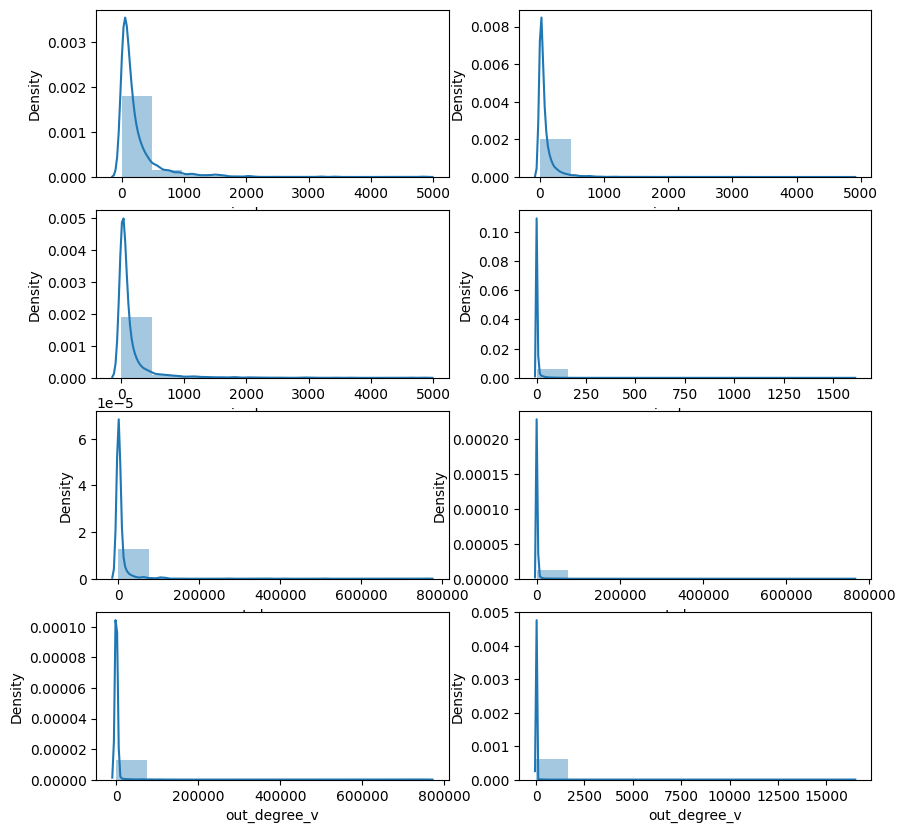

In [77]:
# Dist plots for indegree_u, indegree_v, outdegree_u, outdegree_v with respect to label
plt.figure(figsize=(10, 10))
plt.subplot(4, 2, 1)
sns.distplot(df_train[df_train['label'] == 1]['in_degree_u'], hist=True, kde=True, bins=10)
plt.subplot(4, 2, 2)
sns.distplot(df_train[df_train['label'] == 0]['in_degree_u'], hist=True, kde=True, bins=10)
plt.subplot(4, 2, 3)
sns.distplot(df_train[df_train['label'] == 1]['in_degree_v'], hist=True, kde=True, bins=10)
plt.subplot(4, 2, 4)
sns.distplot(df_train[df_train['label'] == 0]['in_degree_v'], hist=True, kde=True, bins=10)
plt.subplot(4, 2, 5)
sns.distplot(df_train[df_train['label'] == 1]['out_degree_u'], hist=True, kde=True, bins=10)
plt.subplot(4, 2, 6)
sns.distplot(df_train[df_train['label'] == 0]['out_degree_u'], hist=True, kde=True, bins=10)
plt.subplot(4, 2, 7)
sns.distplot(df_train[df_train['label'] == 1]['out_degree_v'], hist=True, kde=True, bins=10)
plt.subplot(4, 2, 8)
sns.distplot(df_train[df_train['label'] == 0]['out_degree_v'], hist=True, kde=True, bins=10)
plt.show()

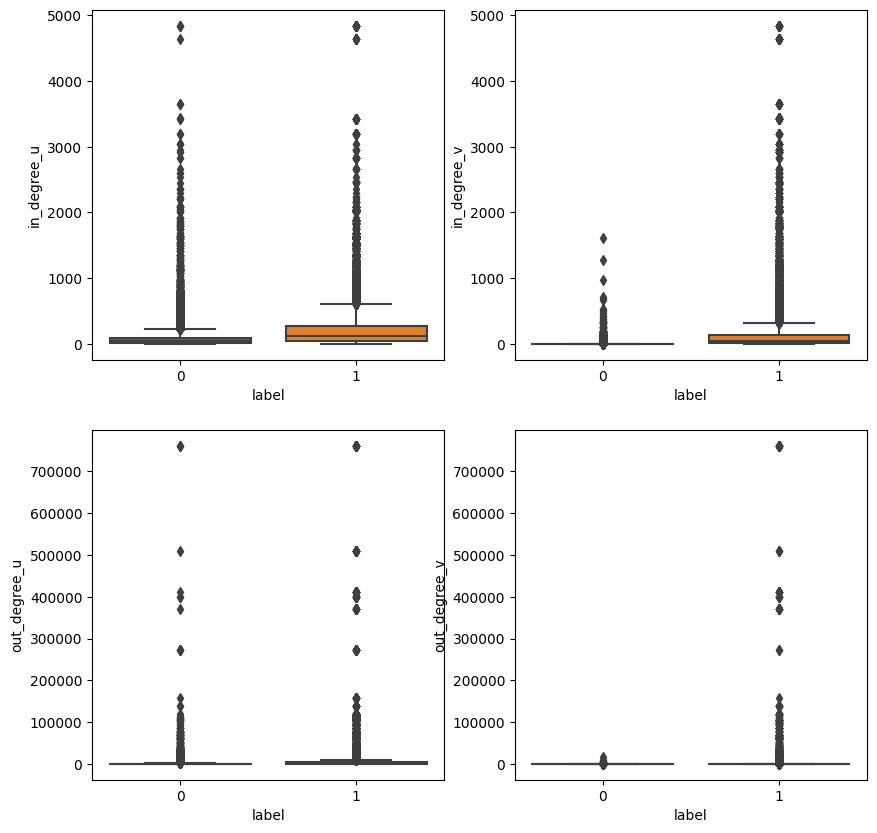

In [78]:
# Bivariate analysis between in_degree_u and in_degree_v with respect to label
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='label', y='in_degree_u', data=df_train)
plt.subplot(2, 2, 2)
sns.boxplot(x='label', y='in_degree_v', data=df_train)
plt.subplot(2, 2, 3)
sns.boxplot(x='label', y='out_degree_u', data=df_train)
plt.subplot(2, 2, 4)
sns.boxplot(x='label', y='out_degree_v', data=df_train)
plt.show()

<Axes: xlabel='jaccard_coeff_succ', ylabel='Density'>

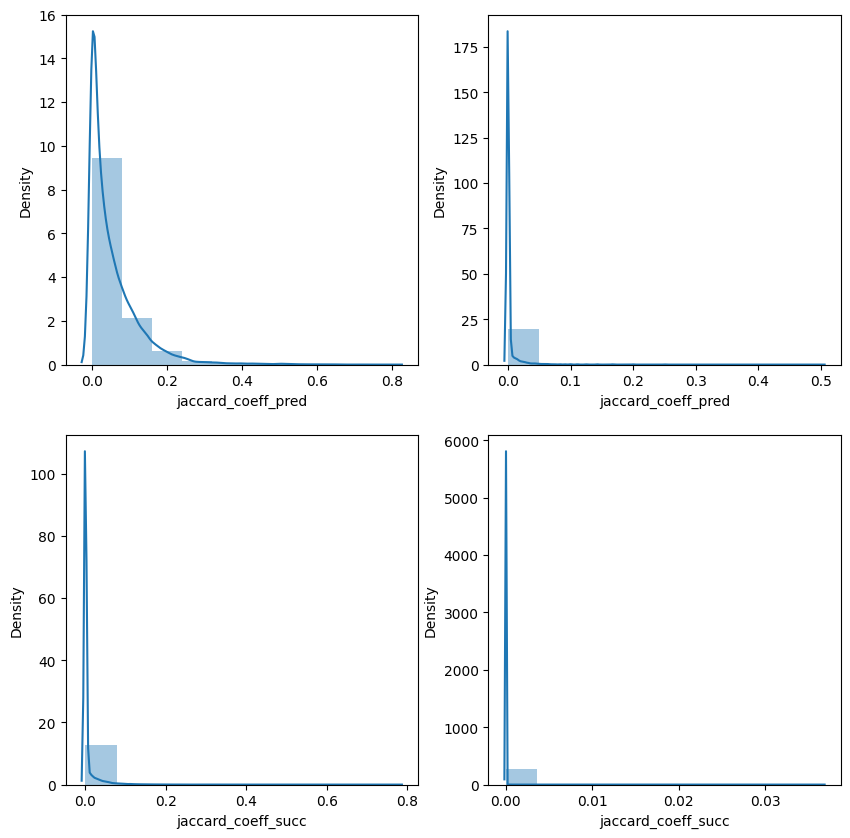

In [79]:
# Analysis of jaccard_coeff_pred, jaccard_coeff_succ, page_rank_u, page_rank_v using bins
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_train[df_train['label'] == 1]['jaccard_coeff_pred'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 2)
sns.distplot(df_train[df_train['label'] == 0]['jaccard_coeff_pred'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 3)
sns.distplot(df_train[df_train['label'] == 1]['jaccard_coeff_succ'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 4)
sns.distplot(df_train[df_train['label'] == 0]['jaccard_coeff_succ'], hist=True, kde=True, bins=10)

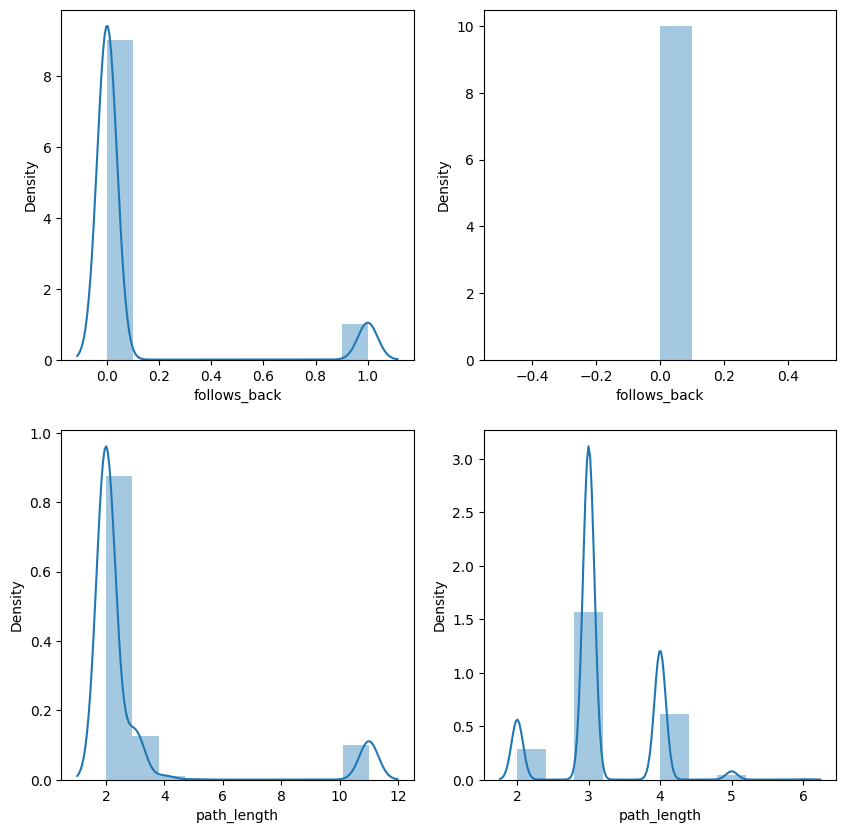

In [80]:
# Analysis of follows_back, path_length using bins
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_train[df_train['label'] == 1]['follows_back'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 2)
sns.distplot(df_train[df_train['label'] == 0]['follows_back'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 3)
sns.distplot(df_train[df_train['label'] == 1]['path_length'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 4)
sns.distplot(df_train[df_train['label'] == 0]['path_length'], hist=True, kde=True, bins=10)
plt.show()

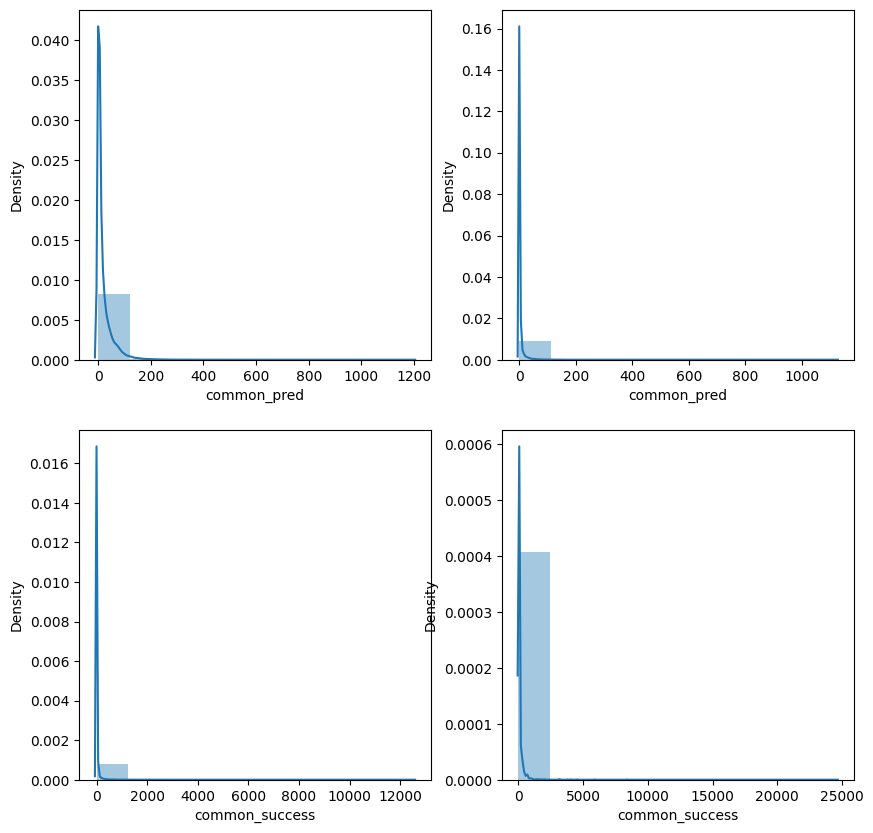

In [ ]:
# Analysis of common_pred, common_success, reverse_path_length using bins
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_train[df_train['label'] == 1]['common_pred'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 2)
sns.distplot(df_train[df_train['label'] == 0]['common_pred'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 3)
sns.distplot(df_train[df_train['label'] == 1]['common_success'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 4)
sns.distplot(df_train[df_train['label'] == 0]['common_success'], hist=True, kde=True, bins=10)
plt.show()

In [ ]:
# Analysis of 

# store train.csv

In [ ]:
df_train['label'].value_counts()
df_train.to_csv('../data/df_train_gen1_stratified_sampling.csv', index=False)

# Model
## Split and normalize train and validation data

In [81]:
def test_train(df_train):
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label'], axis=1), df_train['label'],
                                                        test_size=0.25, random_state=42, stratify=df_train['label'])
    return X_train, X_test, y_train, y_test


In [ ]:
# X_train, X_test, y_train, y_test = test_train(df_train_new)

In [82]:
def predict_accuracy(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_hat = model.predict(X_val)
    print("F1-score:", f1_score(y_val, y_hat))
    print("Accuracy:", accuracy_score(y_val, y_hat))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_hat))
    y_pred_proba = model.predict_proba(X_val)[::, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    a = auc(fpr, tpr)
    print("AUC:", a)

    return y_pred_proba

In [ ]:
print(features)

In [235]:
# rename the features
df_train = df_train.rename(columns={"rv_path_length":"rev_path_length"}) 

<Axes: >

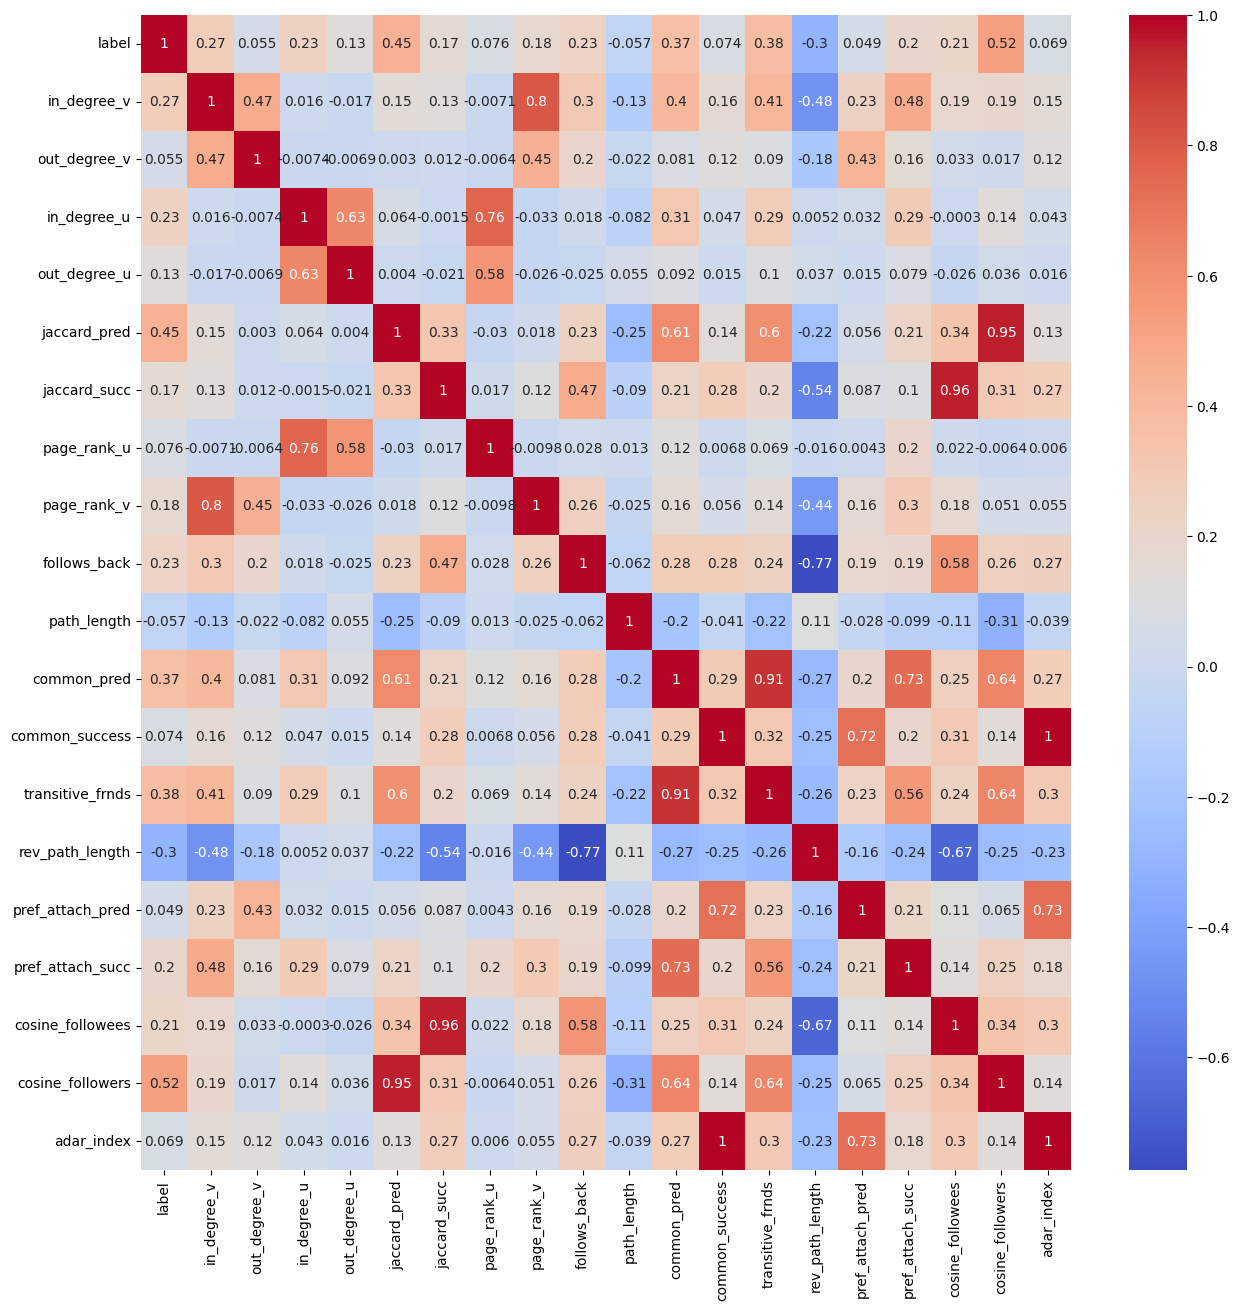

In [236]:
# Find the correlation between the features using heat map
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')

In [277]:
# Drop the features with high correlation
#reverse_path_length: 0.3631503277538411
ath_length: 0.20602345984423473
page_rank_v: 0.19237034430380123
transitive_frnds: 0.1695921708998706
common_pred: 0.10970458667456967
jaccard_coeff_pred: 0.08399983738992405
in_degree_v: 0.0716611725278698
cosine_followers: 0.07022281469884178
preferential_attachment_succ: 0.0394427051457834
out_degree_u: 0.0327754024929055
use_features = ['label','page_rank_u','page_rank_v','jaccard_coeff_pred','jaccard_coeff_succ','out_degree_u','in_degree_v','follows_back']
# use_features = ['label','path_length','page_rank_v','transitive_frnds','common_pred','jaccard_coeff_pred','in_degree_v','cosine_followers','preferential_attachment_succ','out_degree_u','in_degree_u','preferential_attachment_pred']
# print(use_features)

In [149]:
df_train['reverse_path_length'].value_counts()

11    54522
1      2980
2      1703
3       637
4       118
5        10
Name: reverse_path_length, dtype: int64

In [ ]:
# # df_train.loc[df_train['reverse_path_length']==-1,'reverse_path_length'] = 10
# df_train['reverse_path_length'].value_counts()

In [168]:
X_train

array([[ 0.00000000e+00,  1.77048146e-01,  0.00000000e+00, ...,
         2.53272159e-02,  0.00000000e+00,  0.00000000e+00],
       [ 4.60603471e-03,  4.91417349e-01,  0.00000000e+00, ...,
         2.59924918e-01,  2.10792580e-04,  0.00000000e+00],
       [ 0.00000000e+00, -1.58640054e-01,  2.00000000e+00, ...,
        -3.41256263e-02,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -1.58640054e-01,  1.00000000e+00, ...,
        -3.41256263e-02,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.58640054e-01,  1.00000000e+00, ...,
        -3.41256263e-02,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.58640054e-01,  1.00000000e+00, ...,
        -3.41256263e-02,  0.00000000e+00,  0.00000000e+00]])

In [116]:
from sklearn.decomposition import PCA

In [278]:
# features = ['label','jaccard_coeff_pred', 'jaccard_coeff_success', 'page_rank_source', 'page_rank_target','in_degrees_v','out_degrees_u','follows_back', 'path_length']
# use_features = ['jaccard_coeff_pred', 'jaccard_coeff_success', 'page_rank_source', 'page_rank_target','in_degrees_v','out_degrees_u','follows_back', 'path_length']
X_train, X_val, y_train, y_val = test_train(df_train[use_features])# # Assuming X is your feature matrix

In [279]:
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
# X_val = pca.transform(X_val)
X_val = scaler.transform(X_val)

# Logistic regression

In [ ]:
# df_train.loc[df_train['label'] == 4,'label'] = 1
# df_train['label'].value_counts()

In [280]:
# Logistic Regression
model_lr = LogisticRegression()
y_prob = predict_accuracy(model_lr, X_train, y_train, X_val, y_val)

F1-score: 0.8305938101584481
Accuracy: 0.8473954512105649
Confusion Matrix:
 [[7096  404]
 [1884 5609]]
AUC: 0.9445127007429156


In [90]:
model_lr.coef_

array([[0.08184197, 0.45718477, 2.10462501, 1.43833258]])

AUC: 0.8473493304862316


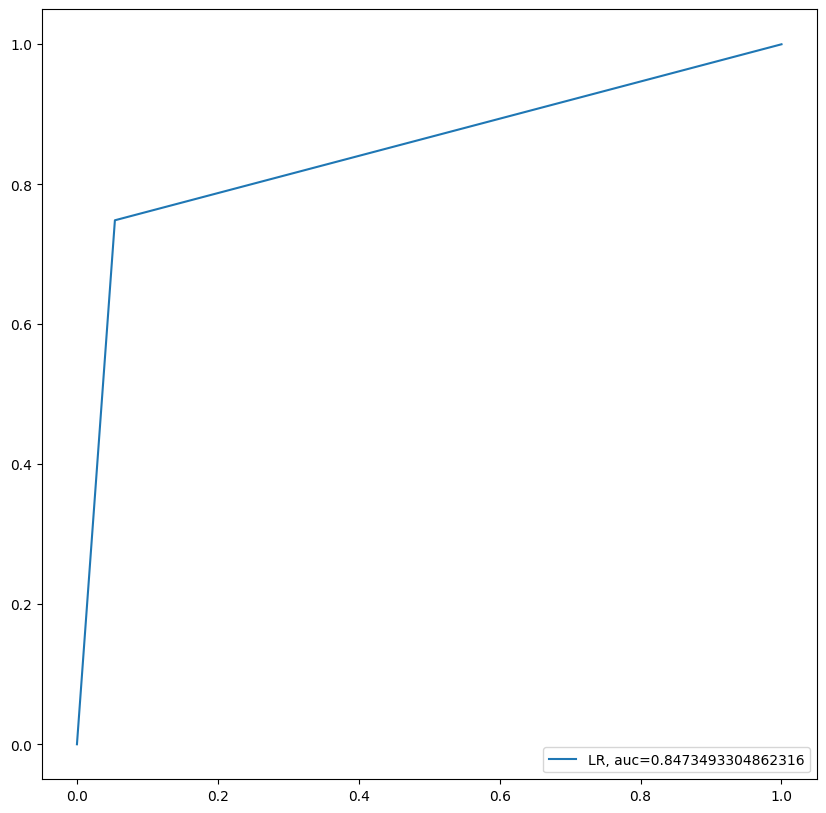

In [281]:
# draw confusion matrix for the model and auc curve
y_hat = model_lr.predict(X_val)
fpr, tpr, _ = roc_curve(y_val,  y_hat)
a = auc(fpr,tpr)
print("AUC:",a)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,label="LR, auc="+str(a))
plt.legend(loc=4)
plt.show()

<Axes: >

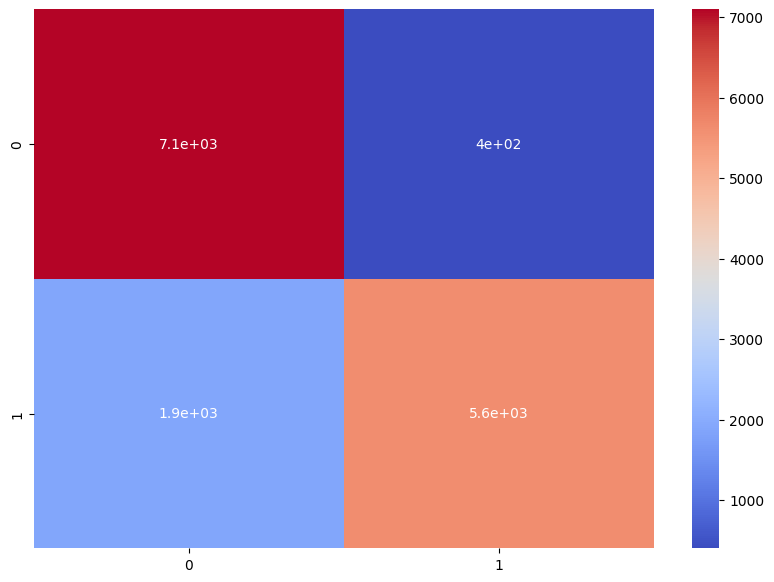

In [282]:
y_hat = model_lr.predict(X_val)
y_hat = (y_hat > 0.5)
cm = confusion_matrix(y_val, y_hat)
df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='coolwarm')

# Create KNN model

In [ ]:
# Create weighted KNN model and predict the class label for test data
model_KNN = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
y_prob = predict_accuracy(model_KNN, X_train, y_train, X_val, y_val)

# Random Forests classifier

In [284]:
# train random forest classifier on train data and return the probability of class 1
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, y_train)
# feature_importances = rf.feature_importances_
y_prob = predict_accuracy(rf, X_train, y_train, X_val, y_val)

F1-score: 0.89043358568479
Accuracy: 0.893817114653505
Confusion Matrix:
 [[6932  568]
 [1024 6469]]
AUC: 0.9709281017838871


AUC: 0.8938028915877042


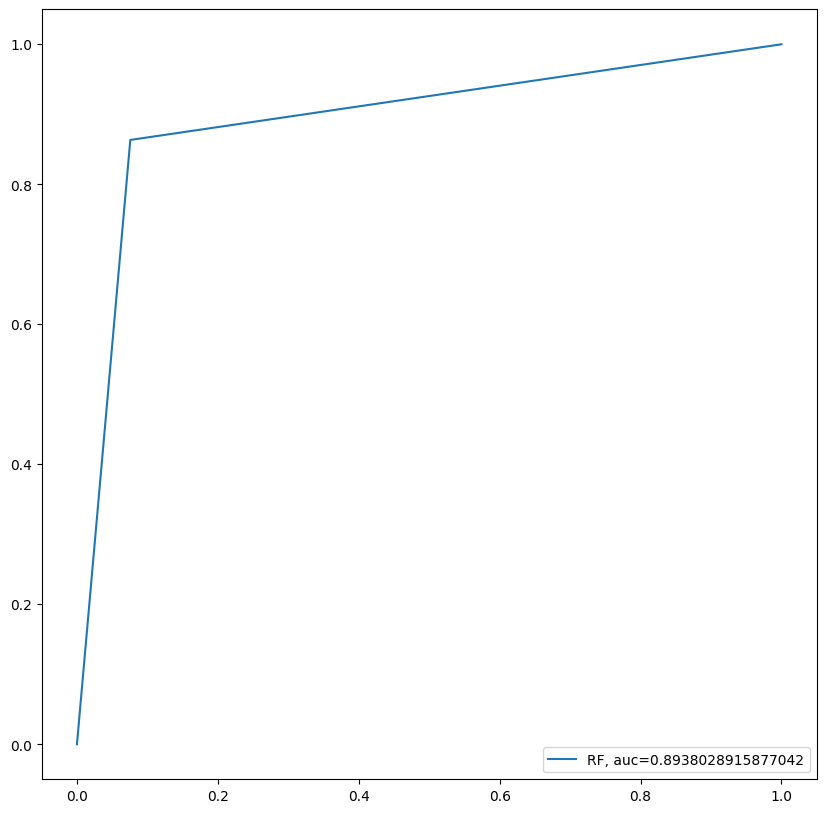

In [286]:
# draw confusion matrix for the model and auc curve
y_hat = rf.predict(X_val)
fpr, tpr, _ = roc_curve(y_val,  y_hat)
a = auc(fpr,tpr)
print("AUC:",a)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,label="RF, auc="+str(a))
plt.legend(loc=4)
plt.show()

<Axes: >

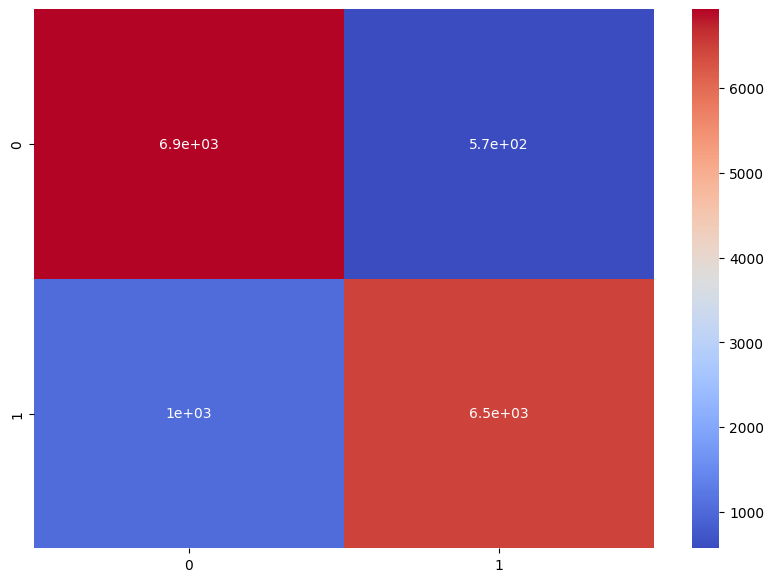

In [287]:
y_hat = rf.predict(X_val)
y_hat = (y_hat > 0.5)
cm = confusion_matrix(y_val, y_hat)
df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='coolwarm')

path_length: 0.20602345984423473
page_rank_v: 0.19237034430380123
transitive_frnds: 0.1695921708998706
common_pred: 0.10970458667456967
jaccard_coeff_pred: 0.08399983738992405
in_degree_v: 0.0716611725278698
cosine_followers: 0.07022281469884178
preferential_attachment_succ: 0.0394427051457834
out_degree_u: 0.0327754024929055
in_degree_u: 0.009149444664034428
preferential_attachment_pred: 0.0045744533694358205
out_degree_v: 0.003457937304713971
reverse_path_length: 0.0030008763045539415
cosine_followees: 0.002101467699434674
adar_index: 0.0005193810550736905
follows_back: 0.0004978124378592331
page_rank_u: 0.0004823837720383381
jaccard_coeff_succ: 0.00030674557109629594
common_success: 0.00011700384395896707


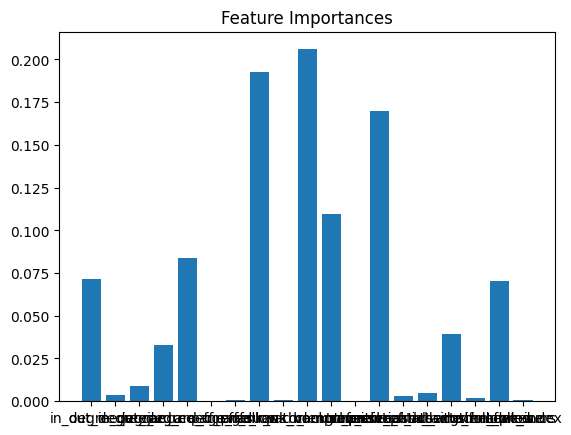

In [243]:
# Print feature importances
feature_names = features[1:]
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

# Plot feature importances
plt.bar(range(len(feature_importances)), feature_importances, tick_label=feature_names)
plt.title('Feature Importances')
plt.show()

# Neural Network

Epoch 1/150
1/1 [==============================] - 5s 5s/step - loss: 0.9043 - accuracy: 0.5954 - val_loss: 0.8580 - val_accuracy: 0.4972
Epoch 2/150
1/1 [==============================] - 1s 655ms/step - loss: 0.8476 - accuracy: 0.6707 - val_loss: 0.8991 - val_accuracy: 0.4998
Epoch 3/150
1/1 [==============================] - 1s 594ms/step - loss: 0.7674 - accuracy: 0.7430 - val_loss: 0.8459 - val_accuracy: 0.4998
Epoch 4/150
1/1 [==============================] - 1s 551ms/step - loss: 0.7236 - accuracy: 0.7653 - val_loss: 0.8422 - val_accuracy: 0.4998
Epoch 5/150
1/1 [==============================] - 1s 552ms/step - loss: 0.6997 - accuracy: 0.7768 - val_loss: 0.8382 - val_accuracy: 0.4998
Epoch 6/150
1/1 [==============================] - 1s 558ms/step - loss: 0.6743 - accuracy: 0.7878 - val_loss: 0.8335 - val_accuracy: 0.4998
Epoch 7/150
1/1 [==============================] - 1s 557ms/step - loss: 0.6610 - accuracy: 0.7907 - val_loss: 0.8282 - val_accuracy: 0.4998
Epoch 8/150
1/1 

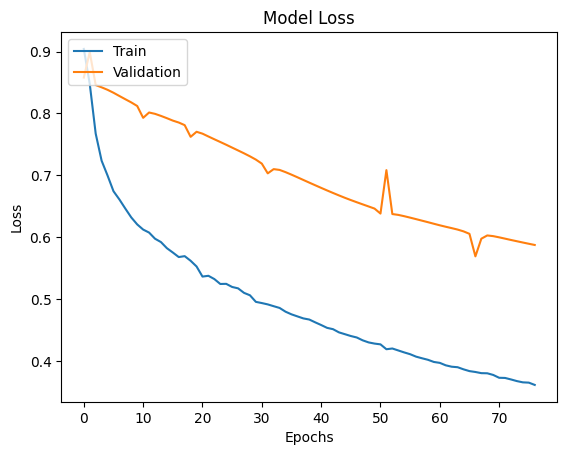

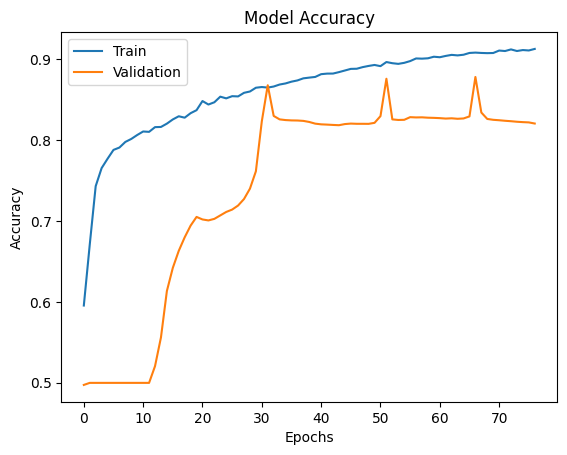

In [268]:
# Train a neural network model on train data and return the probability of class 1 with final layer as sigmoid and loss function as binary_crossentropy and optimizer as adam give prediction for test data use accuracy as metric
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers
from keras import initializers
from keras import callbacks
from keras import backend as K
from keras import utils
from keras import models
from keras import layers
from keras import preprocessing

# add regularizer and dropout to avoid overfitting and underfitting of data and use relu as activation function for hidden layers and sigmoid for final layer
# add batch normalization to avoid vanishing gradient problem and use adam as optimizer and binary_crossentropy as loss function and accuracy as metric
# use early stopping to avoid overfitting of data
# show training and validation loss and accuracy using matplotlib

model = Sequential()
model.add(Dense(100, input_dim=11, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(X_train, y_train, epochs=150, batch_size=50000, validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# plot the training and validation loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

  1/469 [..............................] - ETA: 7s

469/469 [==============================] - 0s 790us/step
AUC: 0.9487165621246497


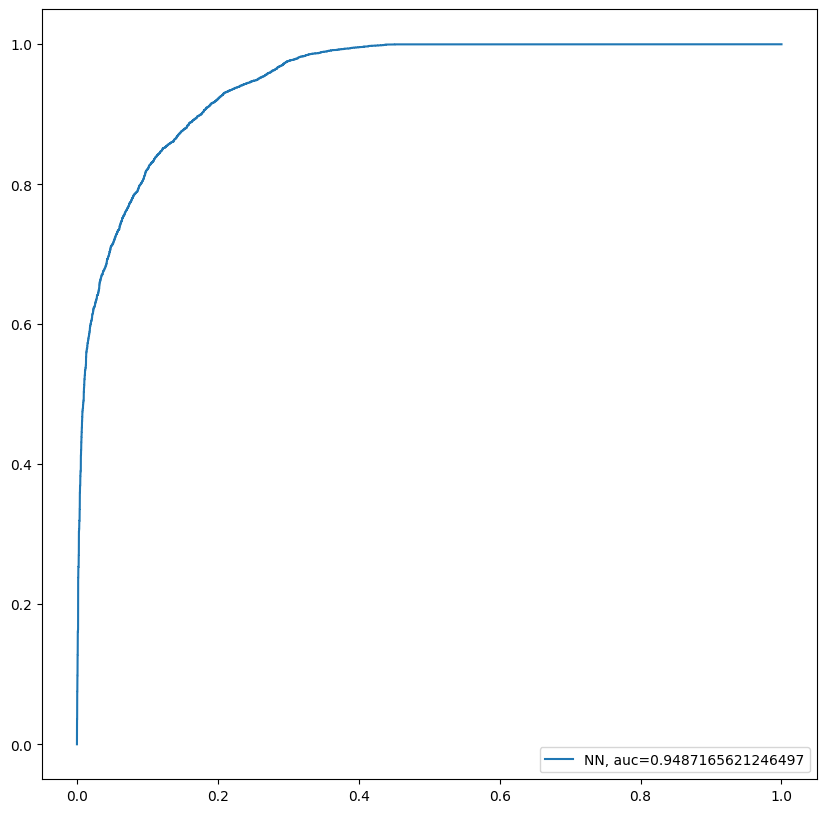

In [227]:
# draw confusion matrix for the model and auc curve
y_hat = model.predict(X_val)
fpr, tpr, _ = roc_curve(y_val,  y_hat)
a = auc(fpr,tpr)
print("AUC:",a)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,label="NN, auc="+str(a))
plt.legend(loc=4)
plt.show()



469/469 [==============================] - 0s 773us/step


<Axes: >

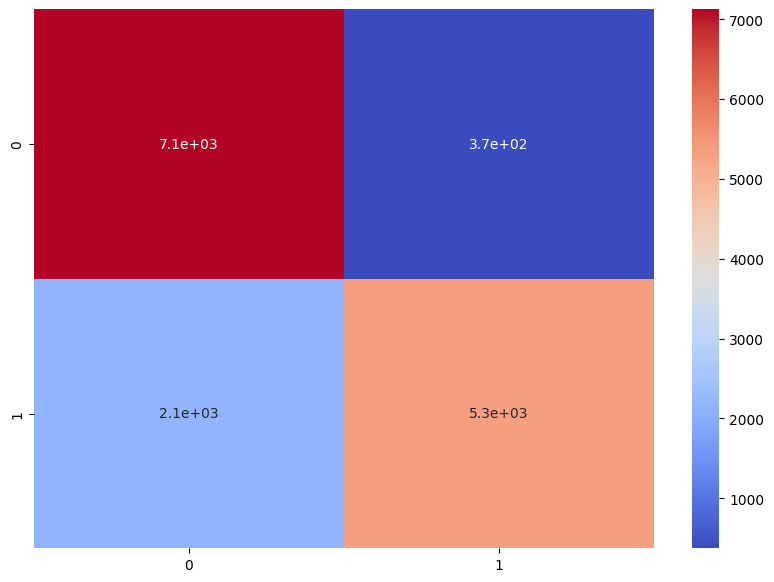

In [228]:
y_hat = model.predict(X_val)
y_hat = (y_hat > 0.5)
cm = confusion_matrix(y_val, y_hat)
df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='coolwarm')

# Load test

In [92]:
df_test = pd.read_csv('../data/test.csv', header=0)
df_test.head()

,Id,From,To
0,1,3360982,4457271
1,2,4761876,4698439
2,3,4198430,3615486
3,4,2945770,747948
4,5,3950088,3360335


# Fetaure Extraction for test data

In [93]:
# Feature extractions for test data based on From and To columns
# ['label','jaccard_coeff_pred', 'jaccard_coeff_success', 'page_rank_source', 'page_rank_target','in_degrees_v','out_degrees_u','follows_back', 'path_length']
df_test['jaccard_coeff_pred'] = df_test.apply(lambda row: jaccard_coeff_predecessors(g, row['From'], row['To']), axis=1)
df_test['jaccard_coeff_succ'] = df_test.apply(lambda row: jaccard_coeff_successors(g, row['From'], row['To']), axis=1)
df_test['page_rank_u'] = df_test.apply(lambda row: pr[row['From']], axis=1)
df_test['page_rank_v'] = df_test.apply(lambda row: pr[row['To']], axis=1)
df_test['follows_back'] = df_test.apply(lambda row: follows_back(row['From'], row['To'], g), axis=1)
df_test['in_degree_u'] = df_test.apply(lambda row: in_degrees[row['From']], axis=1)
df_test['in_degree_v'] = df_test.apply(lambda row: in_degrees[row['To']], axis=1)
df_test['out_degree_u'] = df_test.apply(lambda row: out_degrees[row['From']], axis=1)
df_test['out_degree_v'] = df_test.apply(lambda row: out_degrees[row['To']], axis=1)
df_test['path_length'] = df_test.apply(lambda row: path_length(g, row['From'], row['To']), axis=1)
df_test['common_pred'] = df_test.apply(
    lambda row: len(set(g.predecessors(row['From'])).intersection(set(g.predecessors(row['To'])))), axis=1)
df_test['common_success'] = df_test.apply(
    lambda row: len(set(g.successors(row['From'])).intersection(set(g.successors(row['To'])))), axis=1)
df_test['reverse_path_length'] = df_test.apply(lambda row: reverse_path_length(g, row['From'], row['To']), axis=1)
df_test['transitive_frnds'] = df_test.apply(
    lambda row: len(set(g.successors(row['From'])).intersection(set(g.predecessors(row['To'])))), axis=1)
df_test['reverse_path_length'] = df_test.apply(lambda row: reverse_path_length(g, row['To'], row['From']), axis=1)
df_test['adar_index'] = df_test.apply(lambda row: adar_index(g, row['From'], row['To']), axis=1)
df_test['cosine_followees'] = df_test.apply(lambda row: cosine_followees(g, row['From'], row['To']), axis=1)
df_test['cosine_followers'] = df_test.apply(lambda row: cosine_followers(g, row['From'], row['To']), axis=1)
df_test['preferential_attachment_pred'] = df_test.apply(lambda row: len(set(g.successors(row['From']))) * len(set(g.successors(row['To']))), axis=1)
df_test['preferential_attachment_succ'] = df_test.apply(lambda row: len(set(g.predecessors(row['From']))) * len(set(g.predecessors(row['To']))), axis=1)

In [143]:
df_test.loc[df_test['reverse_path_length'] == -1, 'reverse_path_length'] = 11

In [291]:
df_test1 = df_test.drop(['Id', 'From', 'To'], axis=1)
X_test = df_test1[use_features[1:]]
df_test1.shape

(2000, 19)

In [292]:
# X_test = pca.transform(df_test1[features[1:]])
x_test_norm = scaler.transform(X_test)
# x_test_norm = df_test1

# Test predictions using Logistic Regression model

In [293]:
y_prob = model_lr.predict_proba(x_test_norm)
# return the probability of class 1
y_prob1 = [i[1] for i in y_prob]
#return the no of y_prob1 less than 0.5
sum([1 for i in y_prob1 if i > 0.5])

1234

0.14749221045154595

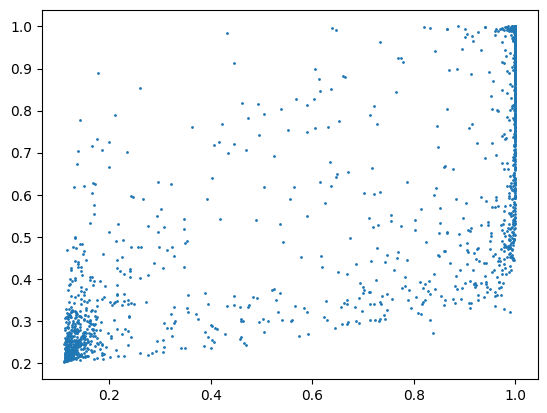

In [294]:
# Read the actual.csv and compare it with y_prob_1 using scatter plot
df_actual = pd.read_csv('../data/actual.csv', header=0)
plt.scatter(df_actual['Predictions'], y_prob1, s=1)
# Mean absolute error between actual and predicted values
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_actual['Predictions'], y_prob1)

<Axes: ylabel='Density'>

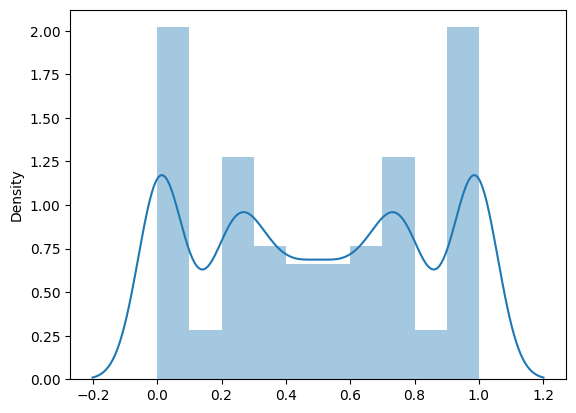

In [295]:
sns.distplot(y_prob, hist=True, kde=True, bins=10)

In [ ]:
print(use_features)

In [173]:
# create a dataframe with Id and Probability as Predictions
df_pred = pd.DataFrame({'Id': df_test['Id'], 'Predictions': y_prob1})
df_pred.to_csv('../data/predictions_lr_0.6lac_stratified_pos.csv', index=False)

# Test Prediction using KNN model

In [ ]:
y_pred_proba = model_KNN.predict_proba(x_test_norm)[::, 1]
y_pred = model_KNN.predict(x_test_norm)
y_pred_proba

In [ ]:
# Read the actual.csv and compare it with y_prob_1 using scatter plot
df_actual = pd.read_csv('../data/actual.csv', header=0)
plt.scatter(df_actual['Predictions'], y_pred_proba, s=1)
# Mean absolute error between actual and predicted values
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_actual['Predictions'], y_pred_proba)

In [ ]:
# create a dataframe with Id and Probability as Predictions
df_pred = pd.DataFrame({'Id': df_test['Id'], 'Predictions': y_pred_proba})
df_pred.to_csv('../data/predictions.csv', index=False)

# Test Prediction using Random Forest model

In [296]:
# calculate prediction for test data using random forest classifier
y_prob_rf_test = rf.predict_proba(x_test_norm)
y_prob1_rf_test = [i[1] for i in y_prob_rf_test]
# y_prob1_rf_test

In [297]:
sum([1 for i in y_prob1_rf_test if i < 0.5])

271

<Axes: ylabel='Density'>

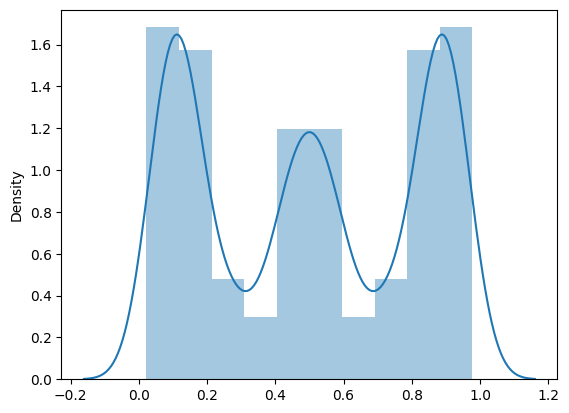

In [298]:
sns.distplot(y_prob_rf_test, hist=True, kde=True, bins=10)

In [ ]:
# Read the actual.csv and compare it with y_prob_1 using scatter plot
df_actual = pd.read_csv('../data/actual.csv', header=0)
plt.scatter(df_actual['Predictions'], y_prob1_rf_test, s=1)
# Mean absolute error between actual and predicted values
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_actual['Predictions'], y_prob1_rf_test)

# Test prediction using Neural network 

25/63 [==========>...................] - ETA: 0s 

63/63 [==============================] - 0s 2ms/step


0.3117570059758374

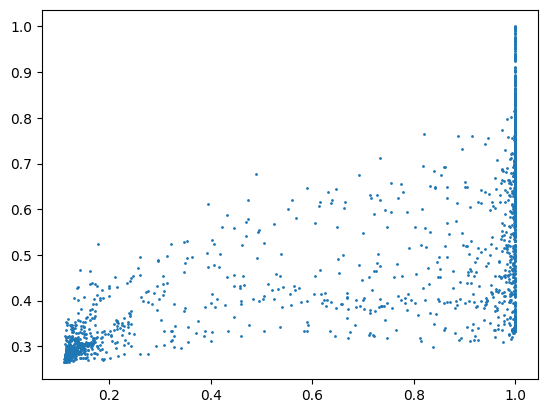

In [273]:

# calculate prediction for test data using neural network classifier
y_prob_nn_test = model.predict(x_test_norm)
y_prob1_nn_test = [i[0] for i in y_prob_nn_test]
# y_prob1_nn_test

# compare the actual and predicted values using scatter plot
plt.scatter(df_actual['Predictions'], y_prob1_nn_test, s=1)
# Mean absolute error between actual and predicted values
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_actual['Predictions'], y_prob1_nn_test)

In [276]:
# sum of y_prob1_nn_test less than 0.5
sum([1 for i in y_prob1_nn_test if  i >0.5])
# min(y_prob1_nn_test)

860

<Axes: ylabel='Density'>

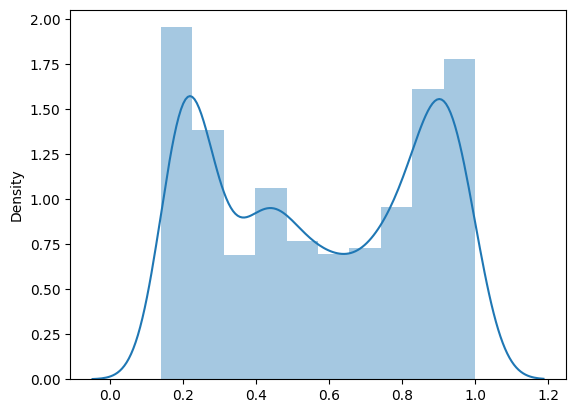

In [255]:
sns.distplot(y_prob1_nn_test, hist=True, kde=True, bins=10)

In [ ]:
# Find the indices of the data points with probability between 0.3 and 0.7
indices = [i for i in range(len(y_prob1_nn_test)) if 0.3 < y_prob1_nn_test[i] < 0.7]
# Find the df_test with probability between 0.3 and 0.7
df_weak = df_test.iloc[indices]

In [ ]:
# Feature analysis of df_weak
# Analysis of jaccard_coeff_pred, jaccard_coeff_succ, page_rank_u, page_rank_v using bins
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_weak['jaccard_coeff_pred'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 2)
sns.distplot(df_weak['jaccard_coeff_succ'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 3)
sns.distplot(df_weak['page_rank_u'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 4)
sns.distplot(df_weak['page_rank_v'], hist=True, kde=True, bins=10)
plt.show()

In [ ]:
# Analysis of follows_back, path_length, common_pred, common_success, reverse_path_length using bins
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_weak['follows_back'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 2)
sns.distplot(df_weak['path_length'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 3)
sns.distplot(df_weak['common_pred'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 4)
sns.distplot(df_weak['common_success'], hist=True, kde=True, bins=10)
plt.show()

# Saving the prediction file

In [259]:
# create a dataframe with Id and Probability as Predictions
df_pred = pd.DataFrame({'Id': df_test['Id'], 'Predictions': y_prob1_nn_test})
df_pred.to_csv('../data/predictions_nn4.csv', index=False)


# After midnight

In [ ]:
# sum if df_actual['Predictions'] > 0.5
sum([1 for i in df_actual['Predictions'] if i < 0.5])

In [ ]:
# train a naive bayes model on train data and return the probability of class 1
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_prob_gnb = predict_accuracy(gnb, X_train, y_train, X_val, y_val)


In [ ]:
# calculate prediction for test data using naive bayes classifier
y_prob_gnb_test = gnb.predict_proba(x_test_norm)
y_prob1_gnb_test = [i[1] for i in y_prob_gnb_test]
y_prob1_gnb_test

In [ ]:
# compare the actual and predicted values using scatter plot
plt.scatter(df_actual['Predictions'], y_prob1_gnb_test, s=1)
# Mean absolute error between actual and predicted values
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_actual['Predictions'], y_prob1_gnb_test)


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, alpha=0.0001,
                    solver='sgd', verbose=10, random_state=21, tol=0.000000001)
y_prob_mlp = predict_accuracy(mlp, X_train, y_train, X_val, y_val)

In [ ]:
# install keras
%pip install keras

In [ ]:
%pip install tensorflow

In [ ]:
y_prob_nn_test = model.predict(x_test_norm)
y_prob1_nn_test = [i[0] for i in y_prob_nn_test]
y_prob1_nn_test

# compare the actual and predicted values using scatter plot
plt.scatter(df_actual['Predictions'], y_prob1_nn_test, s=1)
# Mean absolute error between actual and predicted values
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_actual['Predictions'], y_prob1_nn_test)


In [ ]:
sum([1 for i in y_prob1_nn_test if i < 0.5])

In [ ]:
# calculate confusion matrix for neural network classifier
y_pred_nn = model.predict(X_val).argmax(axis=1)

In [ ]:
# add different colors for different models
plt.scatter(df_actual['Id'], y_prob1_nn_test, s=1, c='r')
plt.scatter(df_actual['Id'], df_actual["Predictions"], s=1, c='b')

In [ ]:
df_pred = pd.DataFrame({'Id': df_test['Id'], 'Predictions': y_prob1_nn_test})
df_pred.to_csv('../data/predictions_nn.csv', index=False)

In [ ]:
# calculate prediction for test data using GNN classifier
y_prob_mlp_test = mlp.predict_proba(x_test_norm)

In [ ]:
# return the probability of class 1
y_prob1_mlp_test = [i[1] for i in y_prob_mlp_test]
y_prob1_mlp_test

In [ ]:
# compare the actual and predicted values using scatter plot
plt.scatter(df_actual['Predictions'], y_prob1_mlp_test, s=1)
# Mean absolute error between actual and predicted values
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_actual['Predictions'], y_prob1_mlp_test)

In [ ]:
# create confusion matrix for mlp classifier
y_pred_mlp = mlp.predict(X_val)
confusion_matrix(y_val, y_pred_mlp)


In [ ]:
df_pred = pd.DataFrame({'Id': df_test['Id'], 'Predictions': y_prob1_mlp_test})
df_pred.to_csv('../data/predictions_mlp.csv', index=False)

In [ ]:
# calculate the number of data points with probability less than 0.5 in df actual
sum([1 for i in df_actual['Predictions'] if i < 0.5])

In [ ]:
sub = pd.read_csv('../data/submission_today.csv', header=0)
# plot the distribution of the predictions
plt.hist(y_prob1_nn_test, bins=100)
plt.hist(df_actual['Predictions'], bins=100)
plt.xlim(0, 1)


In [ ]:
# caluculate number of data points with probability less than 0.5
sum([1 for i in y_prob1_nn_test if i < 0.5])


In [ ]:
sum([1 for i in df_actual['Predictions'] if i < 0.5])

In [ ]:
# Train SVM model on train data and return the probability of class 1
from sklearn import svm

clf = svm.SVC(kernel='linear', probability=True)
y_prob_svm = predict_accuracy(clf, X_train, y_train, X_val, y_val)

# calculate prediction for test data using SVM classifier
y_prob_svm_test = clf.predict_proba(x_test_norm)
y_prob1_svm_test = [i[1] for i in y_prob_svm_test]
y_prob1_svm_test

# compare the actual and predicted values using scatter plot
plt.scatter(df_actual['Predictions'], y_prob1_svm_test, s=1)
# Mean absolute error between actual and predicted values
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_actual['Predictions'], y_prob1_svm_test)


In [ ]:
# construct graph from train_pos and train_ve 
g = nx.DiGraph()
g.add_edges_from(train_pos.keys())
g.add_edges_from(train_ve.keys())


In [ ]:
df_nn = pd.read_csv('../data/predictions_nn.csv', header=0)
# Read the actual.csv and compare it with y_prob_1 using scatter plot
df_actual = pd.read_csv('../data/actual.csv', header=0)


In [ ]:
# number of data points with probability less than 0.5
sum([1 for i in df_nn['Predictions'] if i < 0.5])

In [ ]:
# mae
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_actual['Predictions'], df_nn['Predictions'])


In [ ]:
for i in df_actual['Predictions']:
    if i < 0.5:
        print(i)

In [ ]:
# create 2 lists for actual and predicted values with 1 and 0
actual = []
pred = []
for i in df_actual['Predictions']:
    if i < 0.5:
        actual.append(0)
    else:
        actual.append(1)
for i in df_nn['Predictions']:
    if i < 0.5:
        pred.append(0)
    else:
        pred.append(1)

In [ ]:
# # plot graph for actual and predicted values
# # plt.scatter(df_actual['Id'], actual, s=1, c='r')
# plt.scatter(actual, pred, s=1, c='b')


In [ ]:
count = 0
li = []
for i in range(len(actual)):
    if actual[i] != pred[i]:
        # count += 1
        li.append(i)
        print(actual[i], pred[i], i)
# print(count)

In [ ]:
li[0]

In [ ]:
df_actual['Predictions'][li[0]]

In [ ]:
li

In [ ]:
for i in li:
    print(df_actual['Predictions'][i], df_nn['Predictions'][i])

In [ ]:
# count number where actual is 1 and predicted is 0 in li
sum([1 for i in li if df_actual['Predictions'][i] > df_nn['Predictions'][i]])


In [ ]:
# df_test = pd.read_csv('../data/test.csv', header= 0)
df_test.loc[li, :]['page_rank_source'].value_counts()
# df_test.columns

In [ ]:
df_test['page_rank_target'].max()

In [ ]:
# Plot histogram of out_degrees_u for test data with 10 bins
# plt.hist(df_test['out_degrees_u'], bins=10)
df_test['out_degrees_u'].max()

In [ ]:
df_train_pos['out_degrees_u'].max()

In [ ]:
df_test.shape

In [ ]:
# # Assuming X is your feature matrix
# pca = PCA(n_components='mle')  # 'mle' selects the number of components automatically
# X_pca = pca.fit_transform(X_train)
# 
# # The components_ attribute contains the principal components
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_explained_variance = explained_variance_ratio.cumsum()
# 
# # Plot the cumulative explained variance to decide the number of components to keep
# # Adjust the threshold based on how much variance you want to retain
# plt.plot(cumulative_explained_variance)
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.show()
# 
# # # Choose the number of components based on the plot or a desired threshold
# n_components = 3  # Example: choose 3 components
# # 
# # # Use the selected number of components to transform your data
# pca = PCA(n_components=n_components)
# X_train = pca.fit_transform(X_train)

In [ ]:
# Analysis of indegree_u, indegree_v, outdegree_u, outdegree_v
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.boxplot(y='in_degree_u', data=df_test)
plt.subplot(2, 2, 2)
sns.boxplot(y='in_degree_v', data=df_test)
plt.subplot(2, 2, 3)
sns.boxplot(y='out_degree_u', data=df_test)
plt.subplot(2, 2, 4)
sns.boxplot(y='out_degree_v', data=df_test)

In [ ]:
# Print the frequency of numbers in the bins of out_degree_u, out_degree_v
bin_edges = [-1,1000, 20000, 50000, 100000, 800000]
print(pd.cut(df_test['out_degree_u'], bins=bin_edges).value_counts())
print(pd.cut(df_test['out_degree_v'], bins=bin_edges).value_counts())


In [ ]:
# Analysis of jaccard_coeff_pred, jaccard_coeff_succ, page_rank_u, page_rank_v using bins
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_test['jaccard_coeff_pred'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 2)
sns.distplot(df_test['jaccard_coeff_succ'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 3)
sns.distplot(df_test['page_rank_u'], hist=True, kde=True, bins=2)
plt.subplot(2, 2, 4)
sns.distplot(df_test['page_rank_v'], hist=True, kde=True, bins=2)  # Analysis of follows_back, path_length, common_pred, common_success, reverse_path_length using bins
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_test['follows_back'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 2)
sns.distplot(df_test['path_length'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 3)
sns.distplot(df_test['common_pred'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 4)
sns.distplot(df_test['common_success'], hist=True, kde=True, bins=10)  # Analysis of reverse path length of df_test using bins
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_test['reverse_path_length'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 2)
sns.distplot(df_test['transitive_frnds'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 3)
sns.distplot(df_test['adar_index'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 4)
sns.distplot(df_test['cosine_followees'], hist=True, kde=True, bins=10)
plt.show()  # Analysis of transitive_frnds, adar_index, cosine_followees, cosine_followers using bins
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_test['transitive_frnds'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 2)
sns.distplot(df_test['adar_index'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 3)
sns.distplot(df_test['cosine_followees'], hist=True, kde=True, bins=10)
plt.subplot(2, 2, 4)
sns.distplot(df_test['cosine_followers'], hist=True, kde=True, bins=10)

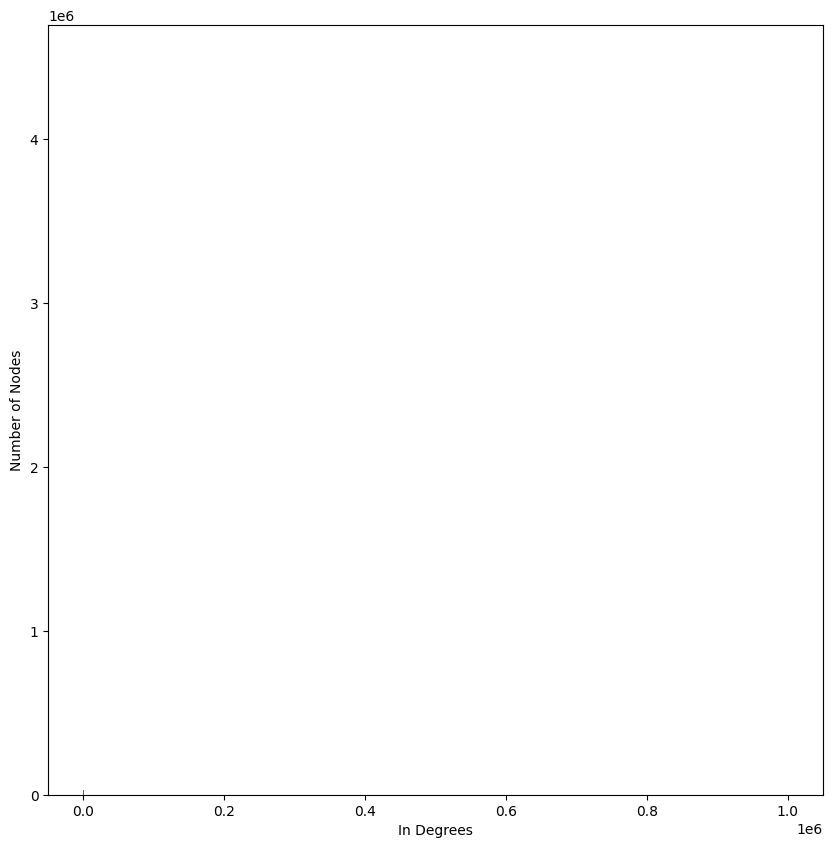

In [289]:
# from graph plot the bar plot of in_degrees using predefined bins
in_degrees = dict(g.in_degree())
in_values = sorted(set(in_degrees.values()))
bins = [0,10,100,1000,10000,100000,1000000]
plt.figure(figsize=(10,10))
plt.hist(list(in_degrees.values()), bins=bins)
plt.xlabel('In Degrees')
plt.ylabel('Number of Nodes')
plt.show()


In [ ]:
out_degrees = dict(g.out_degree())
out_values = sorted(set(out_degrees.values()))
out_hist = [list(out_degrees.values()).count(x) for x in out_values]
plt.figure()
plt.grid(True)
plt.loglog(out_values, out_hist, 'ro-')
plt.xlabel('Out Degrees')
plt.ylabel('Number of Nodes')
plt.title('Out Degree Distribution')
plt.show()